In [36]:
import pandas as pd
import numpy as np

In [37]:
patients = pd.read_csv("/content/patients.csv")
conditions = pd.read_csv("/content/conditions.csv")
observations = pd.read_csv("/content/observations.csv")
medications = pd.read_csv("/content/medications.csv")
procedures = pd.read_csv("/content/procedures.csv")
encounters = pd.read_csv("/content/encounters.csv")

In [38]:
import datetime

current_year = datetime.datetime.now().year

patients['AGE'] = current_year - pd.to_datetime(patients['BIRTHDATE']).dt.year

age_bins = [0, 10, 18, 64, float('inf')]

age_labels = ['0-10 years', '11-18 years', '19-64 years', '65+ years']

patients['AGE_GROUP'] = pd.cut(patients['AGE'], bins=age_bins, labels=age_labels, right=False)

age_group_counts = patients['AGE_GROUP'].value_counts().sort_index()

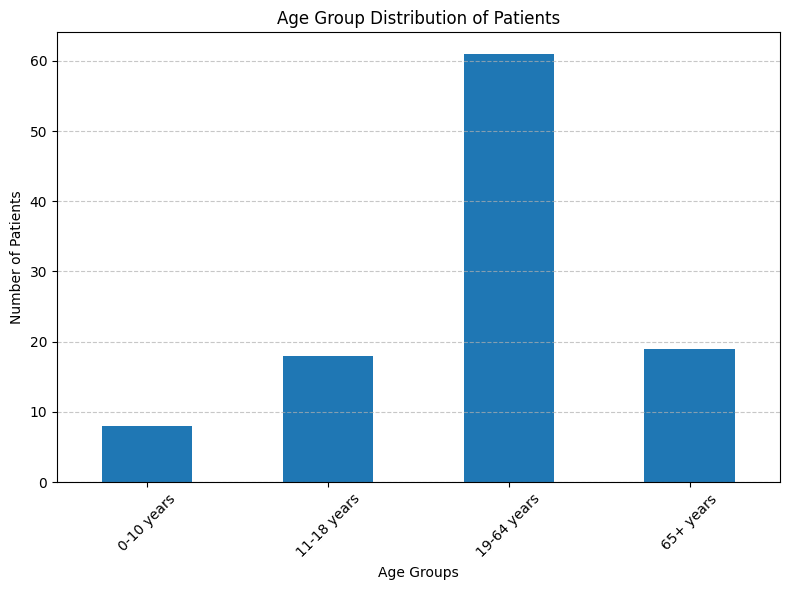

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
age_group_counts.plot(kind='bar')
plt.title('Age Group Distribution of Patients')
plt.xlabel('Age Groups')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [40]:
psychiatric_keywords = ["depression", "anxiety", "schizophrenia", "history"]

psychiatric_conditions = conditions[conditions['DESCRIPTION'].str.contains('|'.join(psychiatric_keywords), case=False, na=False)]

unique_patient_count = psychiatric_conditions['PATIENT'].nunique()

total_patients = conditions['PATIENT'].nunique()

proportion_psychiatric = unique_patient_count / total_patients

summary = pd.DataFrame({
    "Total Patients": [total_patients],
    "Patients with Psychiatric Diagnoses": [unique_patient_count],
    "Proportion with Psychiatric Diagnoses": [proportion_psychiatric]
})

summary


,Total Patients,Patients with Psychiatric Diagnoses,Proportion with Psychiatric Diagnoses
0,106,44,0.415094


In [41]:
phq_observations = observations[observations['DESCRIPTION'].str.contains('PHQ', case=False, na=False)]

phq_observations['VALUE'] = pd.to_numeric(phq_observations['VALUE'], errors='coerce')

relevant_phq_data = phq_observations[['PATIENT', 'DESCRIPTION', 'VALUE']]
phq_high_scores = relevant_phq_data[relevant_phq_data['VALUE'] > 10]

phq_high_scores

<ipython-input-41-2e4c15b2f9c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phq_observations['VALUE'] = pd.to_numeric(phq_observations['VALUE'], errors='coerce')


,PATIENT,DESCRIPTION,VALUE
1849,3648fb36-1cd1-3641-0b1c-1f00d1e7e7de,Generalized anxiety disorder 7 item (GAD-7) to...,11.0
2143,50ca7edb-0dee-35e6-5d8f-66fbcb0b37c1,Patient Health Questionnaire 9 item (PHQ-9) to...,12.0
5965,8935bc21-92f0-a4ad-d8b4-bcdd5b92204a,Patient Health Questionnaire 9 item (PHQ-9) to...,20.0
6261,8935bc21-92f0-a4ad-d8b4-bcdd5b92204a,Generalized anxiety disorder 7 item (GAD-7) to...,21.0
7634,d5635f98-2461-70a1-5916-f854efa27fc0,Patient Health Questionnaire 9 item (PHQ-9) to...,15.0
...,...,...,...
81673,d1622e8b-d26b-ec81-ffcb-ec4bf2af385b,Generalized anxiety disorder 7 item (GAD-7) to...,14.0
81888,d1622e8b-d26b-ec81-ffcb-ec4bf2af385b,Generalized anxiety disorder 7 item (GAD-7) to...,16.0
83098,d1622e8b-d26b-ec81-ffcb-ec4bf2af385b,Generalized anxiety disorder 7 item (GAD-7) to...,20.0
84397,d1622e8b-d26b-ec81-ffcb-ec4bf2af385b,Patient Health Questionnaire 9 item (PHQ-9) to...,23.0


In [42]:
depression_observations = observations[observations['DESCRIPTION'].str.contains('depression', case=False, na=False)]

antidepressant_observations = observations[observations['DESCRIPTION'].str.contains('antidepressant', case=False, na=False)]

depression_patients = depression_observations[['PATIENT', 'DATE']].drop_duplicates()

depression_patients['DATE'] = pd.to_datetime(depression_patients['DATE'])
antidepressant_observations['DATE'] = pd.to_datetime(antidepressant_observations['DATE'])

merged_data = depression_patients.merge(
    antidepressant_observations,
    on='PATIENT',
    suffixes=('_diagnosis', '_treatment'),
    how='left'
)

merged_data['days_to_treatment'] = (merged_data['DATE_treatment'] - merged_data['DATE_diagnosis']).dt.days

no_treatment_90_days = merged_data[
    (merged_data['days_to_treatment'].isna()) | (merged_data['days_to_treatment'] > 90)
]

no_treatment_90_days

,PATIENT,DATE_diagnosis,DATE_treatment,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE,days_to_treatment


In [43]:
psychiatric_keywords = ['psychiatric', 'mental', 'anxiety', 'depression', 'stress', 'psychosis']
psychiatric_conditions = conditions[
    conditions['DESCRIPTION'].str.contains('|'.join(psychiatric_keywords), case=False, na=False)
]


In [44]:
psychiatric_patient_ids = psychiatric_conditions['PATIENT'].unique()


In [45]:
psychiatric_encounters = encounters[
    encounters['Id'].isin(psychiatric_conditions['ENCOUNTER'])
]

In [46]:
unique_codes = psychiatric_encounters['CODE'].unique()

unique_codes

array([162673000, 702927004, 185349003,  50849002,   1505002])

In [47]:
encounter_code_frequency = psychiatric_encounters['CODE'].value_counts()

encounter_code_frequency_df = encounter_code_frequency.reset_index()
encounter_code_frequency_df.columns = ['CODE', 'FREQUENCY']

encounter_code_frequency_df


,CODE,FREQUENCY
0,162673000,162
1,185349003,82
2,702927004,60
3,50849002,7
4,1505002,1
